<a href="https://colab.research.google.com/github/KoMurase/Learning_my_interest/blob/master/%E7%94%BB%E5%83%8F%E7%94%9F%E6%88%90%E7%B7%B4%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import urllib.request
import zipfile
import tarfile

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

In [0]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [38]:

import sklearn
print(sklearn.__version__)

0.21.3


In [0]:
# MNISTの手書き数字画像をダウンロードし読み込みます（2分ほど時間がかかります）
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, data_home="./data/")  
# data_homeは保存先を指定します

In [0]:
# データの取り出し
X = mnist.data
y = mnist.target


この画像データのラベルは5です


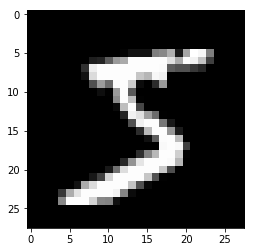

In [41]:
# MNISTのデータの1つ目を可視化する
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{}です".format(y[0]))


In [0]:

# フォルダ「data」の下にフォルダ「img_78」を作成する
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [0]:

# MNISTから数字7、8の画像だけフォルダ「img_78」に画像として保存していく
count7=0
count8=0
max_num=200  # 画像は200枚ずつ作成する

for i in range(len(X)):
    
    # 画像7の作成
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/img_78/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count7+=1 
    
    # 画像8の作成
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count8+=1


ここまでは準備

In [0]:
#import 
import torch 
import torch.nn as nn 
import torch .optim as optim 
import torch.utils.data as data 
import torchvision 
from torchvision import models, transforms 

import glob 
import os.path as osp 
import random 
import numpy as np 
import json 
from tqdm import tqdm
import matplotlib.pyplot as plt 
%matplotlib inline 
from PIL import Image  

In [0]:
class Generator(nn.Module):
  def __init__(self,z_dim=20,image_size=64):
    super(Generator,self).__init__()

    self.layer1 = nn.Sequential(
        nn.ConvTranspose2d(z_dim,image_size * 8, kernel_size=4,stride=1),
        nn.BatchNorm2d(image_size*8),
        nn.ReLU(inplace=True)
    )
    self.layer2 = nn.Sequential(
        nn.ConvTranspose2d(image_size * 8,image_size*4, kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(image_size*4),
        nn.ReLU(inplace=True)
    )
    self.layer3 = nn.Sequential(
        nn.ConvTranspose2d(image_size * 4,image_size*2, kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(image_size*2),
        nn.ReLU(inplace=True)
    )
    self.layer4 = nn.Sequential(
        nn.ConvTranspose2d(image_size * 2,image_size, kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(image_size),
        nn.ReLU(inplace=True)
    )
    self.last=nn.Sequential(
        nn.ConvTranspose2d(image_size, 1, kernel_size=4,stride=2,padding = 1),
    nn.Tanh()
    )

  def forward(self,z):
    out = self.layer1(z)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.last(out)
    return out 

    

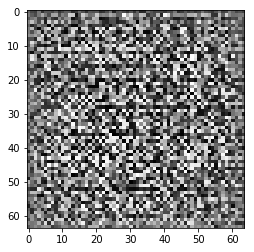

In [46]:
#動作確認
G = Generator(z_dim=20, image_size=64)

#入力する乱数
input_z = torch.randn(1, 20)

#テンソルサイズを(1,20,1,1)に変形
input_z = input_z.view(input_z.size(0),input_z.size(1),1,1)

#偽画像を出力
fake_images = G(input_z)
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


未学習の状態

**画像生成がどのように行われるのか**
生成器が学習して作った画像をどう評価するのかが問題(人の目で判断していてはキリがない)
-->
識別器を同時に学習させ生成した画像に対して評価する

未熟な生成器Gと未熟な識別器Dを上手く交互に学習をすることで本物のような画像を作ることができる

<h2>識別器D ～Discriminator～ の実装</h2>

In [0]:
class Discriminator(nn.Module):
  def __init__(self, z_dim=20, image_size=64):
    super(Discriminator,self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,image_size,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.1,inplace=True)
        #白黒画像を扱うため入力チャンネルは1つだけ
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(image_size,image_size*2,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.1,inplace=True)
        #白黒画像を扱うため入力チャンネルは1つだけ
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(image_size*2,image_size*4,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.1,inplace=True)
        #白黒画像を扱うため入力チャンネルは1つだけ
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(image_size*4,image_size*8,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.1,inplace=True)
        #白黒画像を扱うため入力チャンネルは1つだけ
    )
    self.last = nn.Conv2d(image_size*8,1,kernel_size=4,stride=1)
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.last(out)
    return out 

    

In [61]:
#動作確認
D = Discriminator(z_dim=20,image_size=64)

#偽画像の生成
input_z = torch.randn(1,20) 
input_z = input_z.view(input_z.size(0),input_z.size(1),1,1)
fake_images = G(input_z)

#偽画像をDに入力
d_out = D(fake_images)

#出力d_outにSigmoidをかける
print(nn.Sigmoid()(d_out))

tensor([[[[0.5030]]]], grad_fn=<SigmoidBackward>)
